<a href="https://colab.research.google.com/github/dkeitley/dev-neuro-brainspan/blob/master/dev_neuro_with_brainspan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develpmental Neurobiology with BrainSpan

## Package Installation

In [1]:
!pip install allensdk

## Helper Functions

In [0]:
from allensdk.api.queries.image_download_api import ImageDownloadApi
from allensdk.api.queries.svg_api import SvgApi
from allensdk.api.queries.grid_data_api import GridDataApi
from allensdk.config.manifest import Manifest

import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import urllib.request, json 
from pandas.io.json import json_normalize
import xml.etree.ElementTree as ET


import logging
import os
from base64 import b64encode

from IPython.display import HTML, display

plt.rcParams['figure.dpi']= 300


In [0]:
def verify_image(file_path, figsize=(9, 11),title=""):
    image = imread(file_path)

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    
    
def verify_svg(file_path, width_scale, height_scale):
    # we're using this function to display scaled svg in the rendered notebook.
    # we suggest that in your own work you use a tool such as inkscape or illustrator to view svg
    
    with open(file_path, 'rb') as svg_file:
        svg = svg_file.read()
    encoded_svg = b64encode(svg)
    decoded_svg = encoded_svg.decode('ascii')
    
    st = r'<img class="figure" src="data:image/svg+xml;base64,{}" width={}% height={}%></img>'.format(decoded_svg, width_scale, height_scale)
    display(HTML(st))
    
def find_section(df,section_num):
  mid_section = df.iloc[(df['section_number']-section_num).abs().argsort()][:1]
  return mid_section['id'].item()


In [0]:
image_api = ImageDownloadApi()
svg_api = SvgApi()


In [0]:
def get_gene_expression(url):
  with urllib.request.urlopen(url) as response:
    data = json.loads(response.read())
    donors = json_normalize(data['msg']['samples'])
    exps = json_normalize(data['msg']['probes'],'expression_level',['gene-symbol','id','gene-name','name','gene-id','chromosome','start-position','end-position','entrez-id'])
    exps.rename(columns = {0:'expression_level'}, inplace = True)
    
    return exps,donors
  
def get_gene_id(url):
  id = 0
  with urllib.request.urlopen(url) as response:
    xml = ET.fromstring(response.read()) 
    id_str = xml[0][0][0].text
    id = int(id_str)
  return id

In [0]:
def get_expression_data(gene):
  # Find Gene ID
  # http://api.brain-map.org/api/v2/data/query.xml?criteria=model::Gene,%20rma::criteria,[acronym$eq%27PAX6%27][type$eq%27EnsemblGene%27],organism[name$eq%27Homo%20Sapiens%27],%20rma::options[only$eq%27genes.id%27]
  gene_id_url_1 = "http://api.brain-map.org/api/v2/data/query.xml?criteria=model::Gene,%20rma::criteria,[acronym$eq%27"
  gene_id_url_2 = "%27][type$eq%27EnsemblGene%27],organism[name$eq%27Homo%20Sapiens%27],%20rma::options[only$eq%27genes.id%27]"
  gene_id_url = gene_id_url_1 + gene + gene_id_url_2
  
  id = get_gene_id(gene_id_url)
  
  # Get expression levels 
  # http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_expression[set$eq%27rna_seq_genes%27][probes$eq1087047]
  
  exp_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_expression[set$eq%27rna_seq_genes%27][probes$eq"
  exp_url = exp_url + str(id) + "]"
  exp,don = get_gene_expression(exp_url)
  print(exp.head())

  #return query_url(url_str)

In [310]:
get_expression_data("EOMES")


  expression_level gene-symbol       id     gene-name             name  \
0           5.5537       EOMES  1097980  eomesodermin  ENSG00000163508   
1           5.4418       EOMES  1097980  eomesodermin  ENSG00000163508   
2           5.3666       EOMES  1097980  eomesodermin  ENSG00000163508   
3           5.6339       EOMES  1097980  eomesodermin  ENSG00000163508   
4           5.3185       EOMES  1097980  eomesodermin  ENSG00000163508   

   gene-id chromosome start-position end-position  entrez-id  
0     8262          3            n/a          n/a       8320  
1     8262          3            n/a          n/a       8320  
2     8262          3            n/a          n/a       8320  
3     8262          3            n/a          n/a       8320  
4     8262          3            n/a          n/a       8320  


## Reference Atlases

In [0]:
pcw15_atlas_id = 138322603
pcw21_atlas_id = 3
yr34_atlas_id = 138322605

pcw15_atlas_records = image_api.atlas_image_query(pcw15_atlas_id)
pcw21_atlas_records = image_api.atlas_image_query(pcw21_atlas_id)
yr34_atlas_records = image_api.atlas_image_query(yr34_atlas_id)

pcw15_atlas_section_id = find_section(pd.DataFrame(pcw15_atlas_records),600)
pcw21_atlas_section_id = find_section(pd.DataFrame(pcw21_atlas_records),1500)
yr34_atlas_section_id = find_section(pd.DataFrame(yr34_atlas_records),1400)



In [13]:
file_path = 'annotation.jpg'
image_api.download_atlas_image(pcw15_atlas_section_id, "15pcw_atlas.jpg", annotation=True, downsample=4)
image_api.download_atlas_image(pcw21_atlas_section_id, "21pcw_atlas.jpg", annotation=True, downsample=4)
image_api.download_atlas_image(yr34_atlas_section_id, "34yr_atlas.jpg", annotation=True, downsample=4)

fig, ax = plt.subplots(ncols=3, figsize=(20, 44))
pcw15_image = imread("15pcw_atlas.jpg")
pcw21_image = imread("21pcw_atlas.jpg")
yr34_image = imread("34yr_atlas.jpg")

ax[0].imshow(pcw15_image)
ax[1].imshow(pcw21_image)
ax[2].imshow(yr34_image)


2018-12-10 11:00:40,794 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/102125559?downsample=4&annotation=true
2018-12-10 11:00:41,327 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/101892607?downsample=4&annotation=true
2018-12-10 11:00:42,071 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/atlas_image_download/112282839?downsample=4&annotation=true


In [0]:
pd.DataFrame(pcw15_atlas_records)

# Neurogenesis

In [0]:
pax6_section_id = 100143447
pax6_image_id = 102187868

tbr2_section_id = 100142338
tbr2_image_id = 102166887

downsample = 5
format_str = '.jpg'

pax6_records = image_api.section_image_query(pax6_section_id)



In [0]:
def download_section(section_id,section_image_directory):
  section_images = image_api.section_image_query(section_id)
  section_image_ids = [si['id'] for si in section_images]

  logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = True

  for section_image_id in section_image_ids:

      file_name = str(section_image_id) + format_str
      file_path = os.path.join(section_image_directory, file_name)

      Manifest.safe_make_parent_dirs(file_path)
      image_api.download_section_image(section_image_id, file_path=file_path, downsample=downsample)

  logging.getLogger('allensdk.api.api.retrieve_file_over_http').disabled = False

In [0]:
download_section(pax6_section_id,"pax6")
download_section(tbf2_section_id,"tbf2")

pax6_file_path = os.path.join("pax6",str(pax6_image_id) + format_str)
tbr2_file_path = os.path.join("tbf2",str(tbf2_image_id) + format_str)



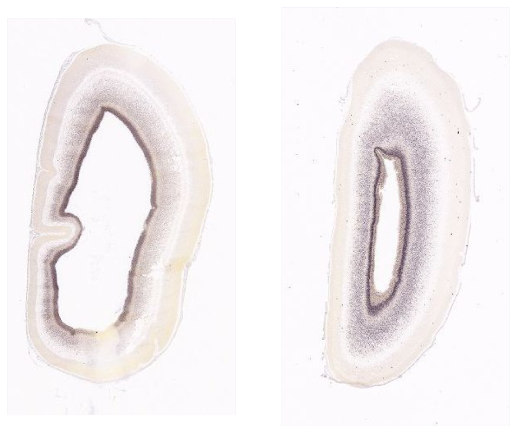

In [17]:

pax6_tbr2_file_paths = [pax6_file_path,tbr2_file_path]

fig, ax = plt.subplots(ncols=2, figsize=(9, 11))
pax6_image = imread(pax6_file_path)
tbr2_image = imread(tbr2_file_path)

ax[0].imshow(pax6_image)
ax[1].imshow(tbr2_image)


ax[ii].get_xaxis().set_visible(False)
ax[ii].get_yaxis().set_visible(False)

# Cortical Arealisation



1.   Relate brain regions with their caudal-rostral and lateral-medial position
2.   

